In [87]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

In [88]:
import matplotlib as plt
import seaborn as sns

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [92]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [93]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [94]:
from prophet import Prophet

In [95]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler  # <-- Corrected from MixMaxScaler


# You can now use the MinMaxScaler in your subsequent code, for example:
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(your_data_frame)



In [97]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import joblib
import os

In [98]:
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

✅ All libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0


In [100]:
import matplotlib.pyplot as plt

 Data loaded: 5,475 rows 40 columns
Date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00

 Training models for: Milk_1L
 Data points: 365


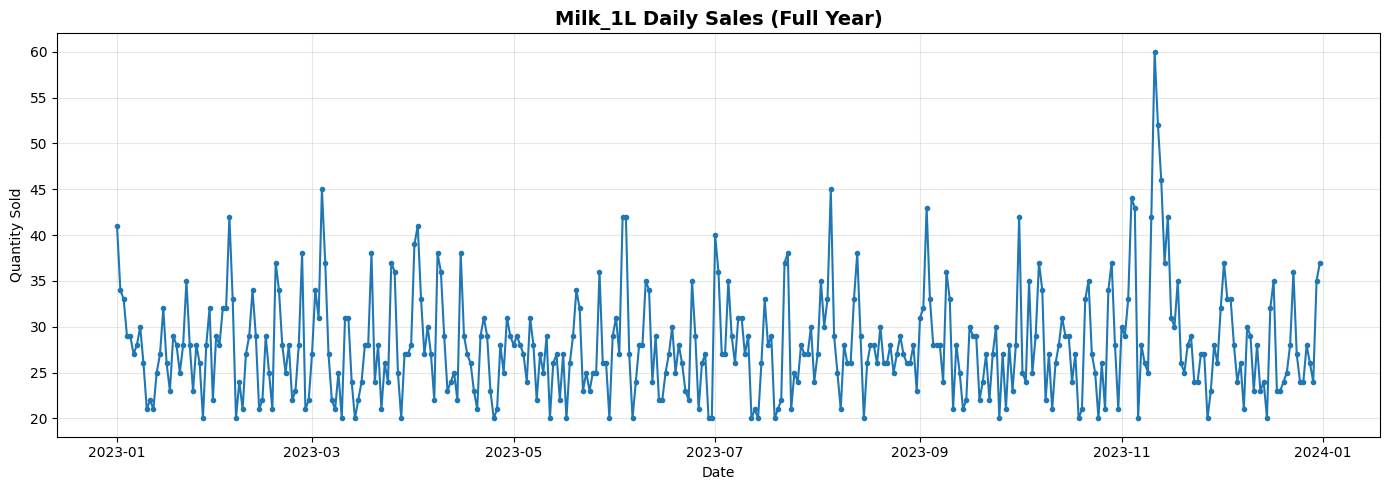

In [101]:
# Load featured dataset
# The 'r' prefix tells Python to treat backslashes literally
df = pd.read_csv(r"C:\Users\karta\Documents\billmitra\data\processed\featured_indian_retail.csv")
df['Date'] = pd.to_datetime(df['Date'])

print(f" Data loaded: {len(df):,} rows {len(df.columns)} columns")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# For this tutorial, Let's focus on ONE product
# (You can loop through all products later!)
PRODUCT = 'Milk_1L'
product_df = df[df['ProductName'] == PRODUCT].copy()
product_df = product_df.sort_values('Date').reset_index(drop=True)

print(f"\n Training models for: {PRODUCT}")
print(f" Data points: {len(product_df):,}")

# Visualize the data (assuming plt is imported as matplotlib.pyplot)
# You need 'import matplotlib.pyplot as plt' at the top of your notebook/script
plt.figure(figsize=(14, 5))
plt.plot(product_df['Date'], product_df['QuantitySold'], marker='o', markersize=3)
plt.title(f'{PRODUCT} Daily Sales (Full Year)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 Data Split:
   Training: 292 days (2023-01-01 00:00:00 to 2023-10-19 00:00:00)
   Testing:  73 days (2023-10-20 00:00:00 to 2023-12-31 00:00:00)


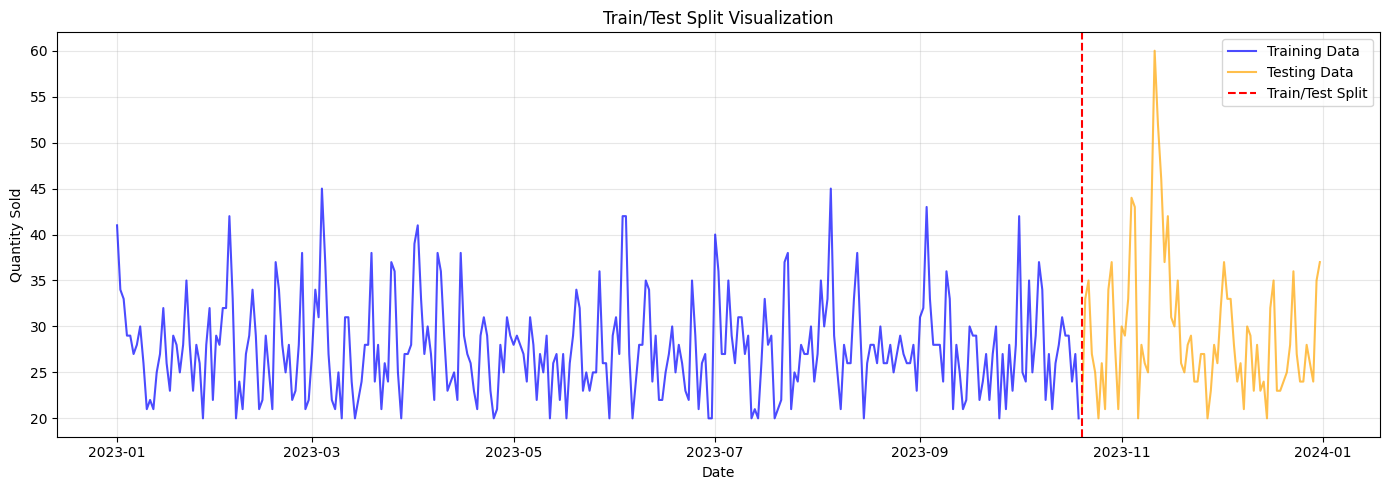

In [102]:
# Split: 80% train, 20% test
# Time series: MUST split chronologically (not random!)
split_index = int(len(product_df) * 0.8)

train_df = product_df.iloc[:split_index].copy()
test_df = product_df.iloc[split_index:].copy()

print(f"📊 Data Split:")
print(f"   Training: {len(train_df)} days ({train_df['Date'].min()} to {train_df['Date'].max()})")
print(f"   Testing:  {len(test_df)} days ({test_df['Date'].min()} to {test_df['Date'].max()})")

# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train_df['Date'], train_df['QuantitySold'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test_df['Date'], test_df['QuantitySold'], label='Testing Data', color='orange', alpha=0.7)
plt.axvline(x=test_df['Date'].iloc[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('Train/Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [103]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and display model performance metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} Performance Metrics")
    print(f"{'='*50}")
    print(f"MAE (Mean Absolute Error):      {mae:.2f} units")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f} units")
    print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")
    print(f"R² Score:                       {r2:.4f}")
    print(f"{'='*50}")
    
    return {
        'model': model_name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

# Example of what these metrics mean:
print("📚 Metric Explanations:")
print("  MAE:  Average prediction error (lower is better)")
print("  RMSE: Penalizes large errors more (lower is better)")
print("  MAPE: Error as percentage (lower is better)")
print("  R²:   How well model fits data (higher is better, max 1.0)")

📚 Metric Explanations:
  MAE:  Average prediction error (lower is better)
  RMSE: Penalizes large errors more (lower is better)
  MAPE: Error as percentage (lower is better)
  R²:   How well model fits data (higher is better, max 1.0)


🤖 Training ARIMA Model...
✅ ARIMA(5,1,2) model trained!

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           QuantitySold   No. Observations:                  292
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -865.570
Date:                Sat, 20 Dec 2025   AIC                           1747.140
Time:                        02:17:18   BIC                           1776.527
Sample:                             0   HQIC                          1758.912
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2037      0.096      2.129      0.033       0.016       0.391
ar.L2         -0.6406      0.068     -9.473      0.000     

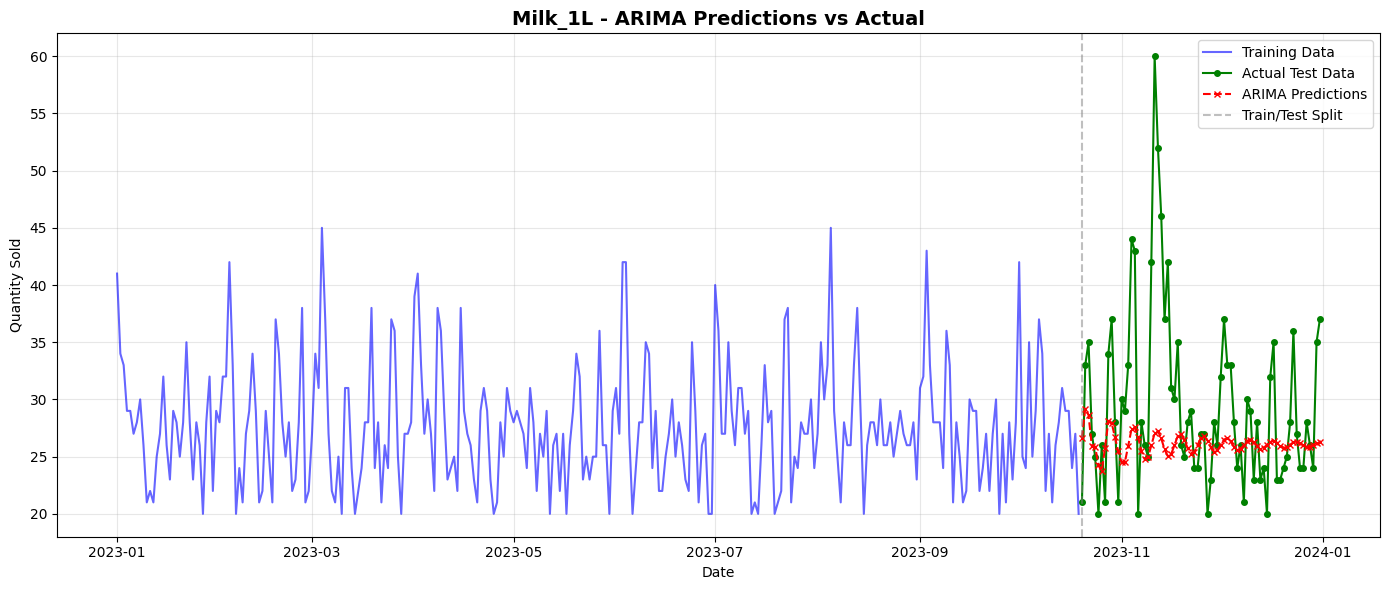


💾 Model saved to: ../models/arima_Milk_1L.pkl


In [104]:
print("🤖 Training ARIMA Model...")
print("="*50)

# ARIMA parameters (p, d, q)
# p = number of lag observations (how many past days to use)
# d = degree of differencing (how many times to subtract previous value)
# q = size of moving average window

# For simplicity, we'll use ARIMA(5, 1, 2)
# You can experiment with different values!

p, d, q = 5, 1, 2

# Fit ARIMA model on training data
arima_model = ARIMA(train_df['QuantitySold'], order=(p, d, q))
arima_fitted = arima_model.fit()

print(f"✅ ARIMA({p},{d},{q}) model trained!")
print(f"\nModel Summary:")
print(arima_fitted.summary())

# Make predictions on test set
arima_predictions = arima_fitted.forecast(steps=len(test_df))

# Evaluate
arima_metrics = evaluate_model(
    test_df['QuantitySold'].values,
    arima_predictions,
    "ARIMA"
)

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['QuantitySold'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test_df['Date'], test_df['QuantitySold'], label='Actual Test Data', color='green', marker='o', markersize=4)
plt.plot(test_df['Date'], arima_predictions, label='ARIMA Predictions', color='red', linestyle='--', marker='x', markersize=4)
plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.title(f'{PRODUCT} - ARIMA Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
os.makedirs('../models', exist_ok=True)
joblib.dump(arima_fitted, f'../models/arima_{PRODUCT}.pkl')
print(f"\n💾 Model saved to: ../models/arima_{PRODUCT}.pkl")

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\i7mvh_9p.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\3kei6vcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=1385', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\i7mvh_9p.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\3kei6vcx.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelz32yj95x\\prophet_model-20251220021718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🤖 Training Prophet Model...
Training Prophet (this may take 30-60 seconds)...


02:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet model trained!

📊 Prophet Performance Metrics
MAE (Mean Absolute Error):      14.53 units
RMSE (Root Mean Squared Error): 18.09 units
MAPE (Mean Absolute % Error):   47.75%
R² Score:                       -4.7045


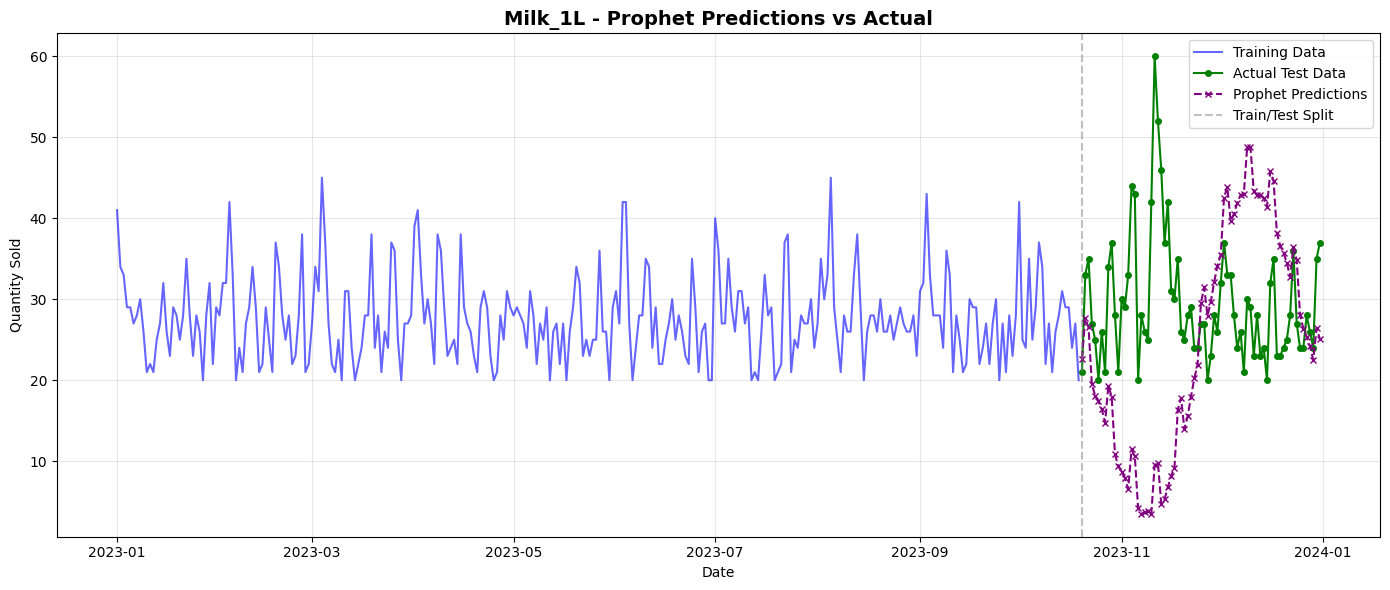

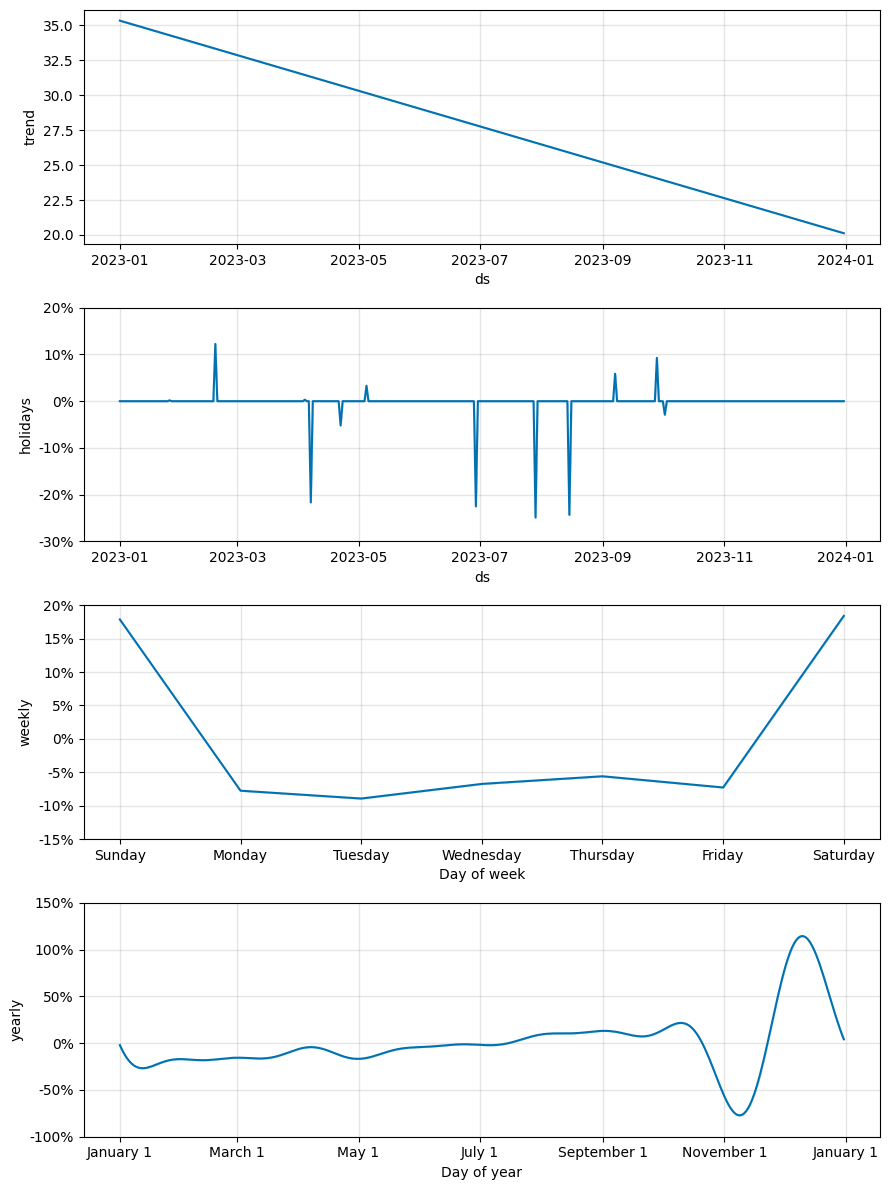


💾 Model saved to: ../models/prophet_Milk_1L.pkl


In [105]:
print("🤖 Training Prophet Model...")
print("="*50)

# Prophet requires specific column names: 'ds' (date) and 'y' (value)
prophet_train = train_df[['Date', 'QuantitySold']].copy()
prophet_train.columns = ['ds', 'y']

prophet_test = test_df[['Date', 'QuantitySold']].copy()
prophet_test.columns = ['ds', 'y']

# Initialize Prophet model
# yearly_seasonality: Capture annual patterns
# weekly_seasonality: Capture weekly patterns (weekends)
# daily_seasonality: Not needed for daily sales data
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # Sales grow proportionally
)

# Add Indian holidays (Diwali, Holi, etc.)
indian_holidays = pd.DataFrame({
    'holiday': ['Diwali', 'Holi', 'Dussehra', 'Eid'],
    'ds': pd.to_datetime(['2024-11-01', '2024-03-25', '2024-10-12', '2024-04-11'])
})

prophet_model = prophet_model.add_country_holidays(country_name='IN')

# Fit model
print("Training Prophet (this may take 30-60 seconds)...")
prophet_model.fit(prophet_train)
print("✅ Prophet model trained!")

# Make predictions
# Prophet needs future dates
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = prophet_model.predict(future)

# Extract test set predictions
prophet_predictions = forecast.iloc[-len(test_df):]['yhat'].values

# Evaluate
prophet_metrics = evaluate_model(
    test_df['QuantitySold'].values,
    prophet_predictions,
    "Prophet"
)

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['QuantitySold'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test_df['Date'], test_df['QuantitySold'], label='Actual Test Data', color='green', marker='o', markersize=4)
plt.plot(test_df['Date'], prophet_predictions, label='Prophet Predictions', color='purple', linestyle='--', marker='x', markersize=4)
plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.title(f'{PRODUCT} - Prophet Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prophet components (trend, weekly, yearly)
fig = prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(prophet_model, f'../models/prophet_{PRODUCT}.pkl')
print(f"\n💾 Model saved to: ../models/prophet_{PRODUCT}.pkl")

🤖 Training LSTM Model...
✅ LSTM dataset created:
   X_train shape: (262, 30, 1) (samples, timesteps, features)
   y_train shape: (262, 1)
   X_test shape:  (43, 30, 1)
   y_test shape:  (43, 1)

📐 LSTM Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


🏋️ Training LSTM (this may take 1-2 minutes)...
✅ LSTM training complete!


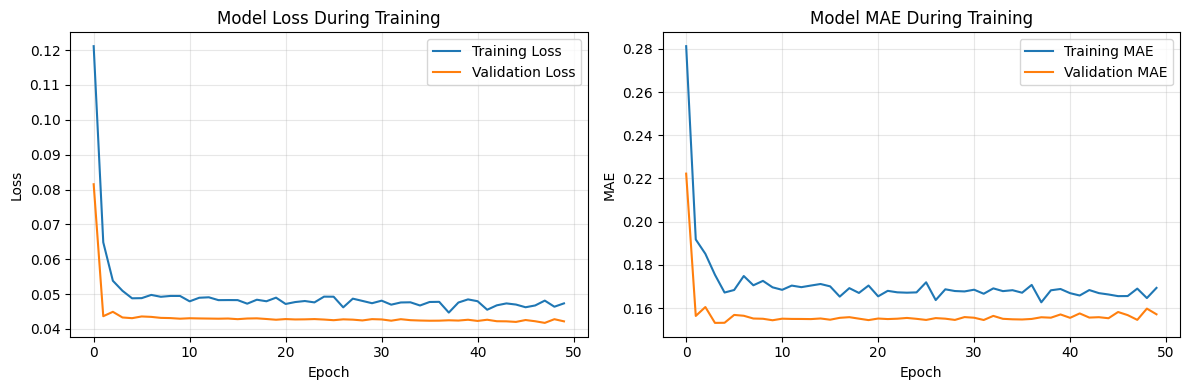


📊 LSTM Performance Metrics
MAE (Mean Absolute Error):      3.60 units
RMSE (Root Mean Squared Error): 4.38 units
MAPE (Mean Absolute % Error):   13.50%
R² Score:                       0.0283


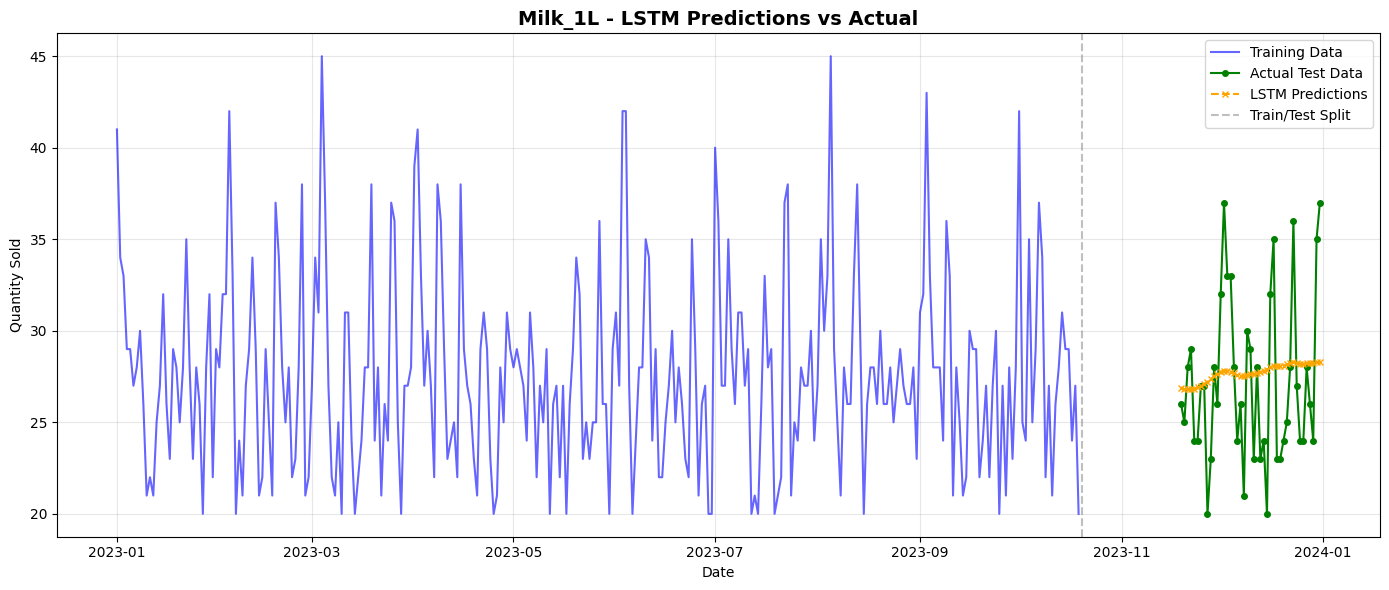


💾 LSTM model saved to: ../models/lstm_Milk_1L.h5
💾 Scaler saved to: ../models/lstm_scaler_Milk_1L.pkl


In [106]:
print("🤖 Training LSTM Model...")
print("="*50)

# LSTM requires 3D input: (samples, timesteps, features)
# We'll use last 30 days to predict next day

LOOKBACK = 30  # Use 30 days of history

# Prepare data
def create_lstm_dataset(data, lookback=30):
    """
    Convert time series to supervised learning format
    
    Example: lookback=3
    Input:  [10, 12, 15, 14, 16] 
    Output: X=[[10,12,15]], y=[14]
            X=[[12,15,14]], y=[16]
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Scale data (LSTM works better with values between 0-1)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['QuantitySold']])
test_scaled = scaler.transform(test_df[['QuantitySold']])

# Create datasets
X_train, y_train = create_lstm_dataset(train_scaled, LOOKBACK)
X_test, y_test = create_lstm_dataset(test_scaled, LOOKBACK)

print(f"✅ LSTM dataset created:")
print(f"   X_train shape: {X_train.shape} (samples, timesteps, features)")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape:  {X_test.shape}")
print(f"   y_test shape:  {y_test.shape}")

# Build LSTM model
model = Sequential([
    # First LSTM layer (returns sequences for next layer)
    LSTM(50, activation='relu', return_sequences=True, input_shape=(LOOKBACK, 1)),
    Dropout(0.2),  # Prevent overfitting
    
    # Second LSTM layer
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    
    # Output layer
    Dense(1)
])

# Compile model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

print("\n📐 LSTM Architecture:")
model.summary()

# Train model
print("\n🏋️ Training LSTM (this may take 1-2 minutes)...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0  # Set to 1 to see training progress
)

print("✅ LSTM training complete!")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Make predictions
lstm_predictions_scaled = model.predict(X_test, verbose=0)

# Unscale predictions back to original range
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_unscaled = scaler.inverse_transform(y_test)

# Evaluate
lstm_metrics = evaluate_model(
    y_test_unscaled.flatten(),
    lstm_predictions.flatten(),
    "LSTM"
)

# Visualize predictions
# Note: LSTM predictions start from day 30 (due to lookback)
test_dates_lstm = test_df['Date'].iloc[LOOKBACK:].reset_index(drop=True)
test_actual_lstm = test_df['QuantitySold'].iloc[LOOKBACK:].reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['QuantitySold'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test_dates_lstm, test_actual_lstm, label='Actual Test Data', color='green', marker='o', markersize=4)
plt.plot(test_dates_lstm, lstm_predictions, label='LSTM Predictions', color='orange', linestyle='--', marker='x', markersize=4)
plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.title(f'{PRODUCT} - LSTM Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
model.save(f'../models/lstm_{PRODUCT}.h5')
joblib.dump(scaler, f'../models/lstm_scaler_{PRODUCT}.pkl')
print(f"\n💾 LSTM model saved to: ../models/lstm_{PRODUCT}.h5")
print(f"💾 Scaler saved to: ../models/lstm_scaler_{PRODUCT}.pkl")

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\n2rif2lz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\_9a2mi56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=83036', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\n2rif2lz.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\_9a2mi56.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_model9a0gcfd3\\prophet_model-20251220021737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🤖 Training Prophet Model...
Training Prophet (this may take 30-60 seconds)...


02:17:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet model trained!

📊 Prophet Performance Metrics
MAE (Mean Absolute Error):      14.53 units
RMSE (Root Mean Squared Error): 18.09 units
MAPE (Mean Absolute % Error):   47.75%
R² Score:                       -4.7045


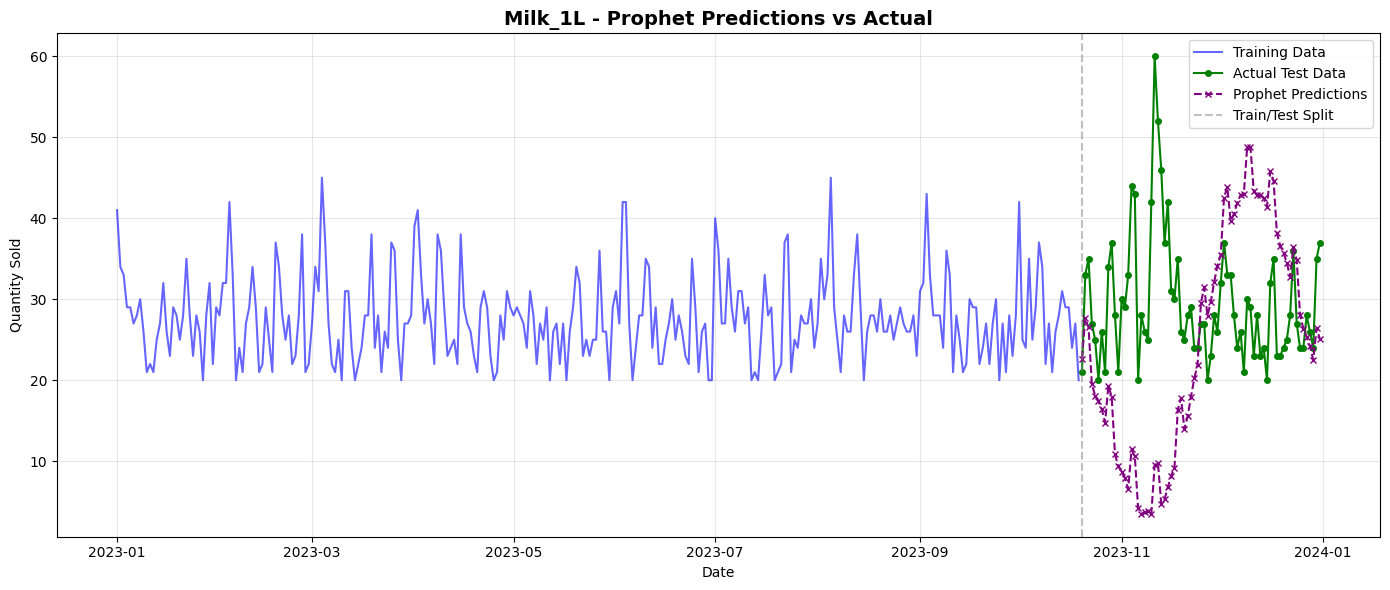

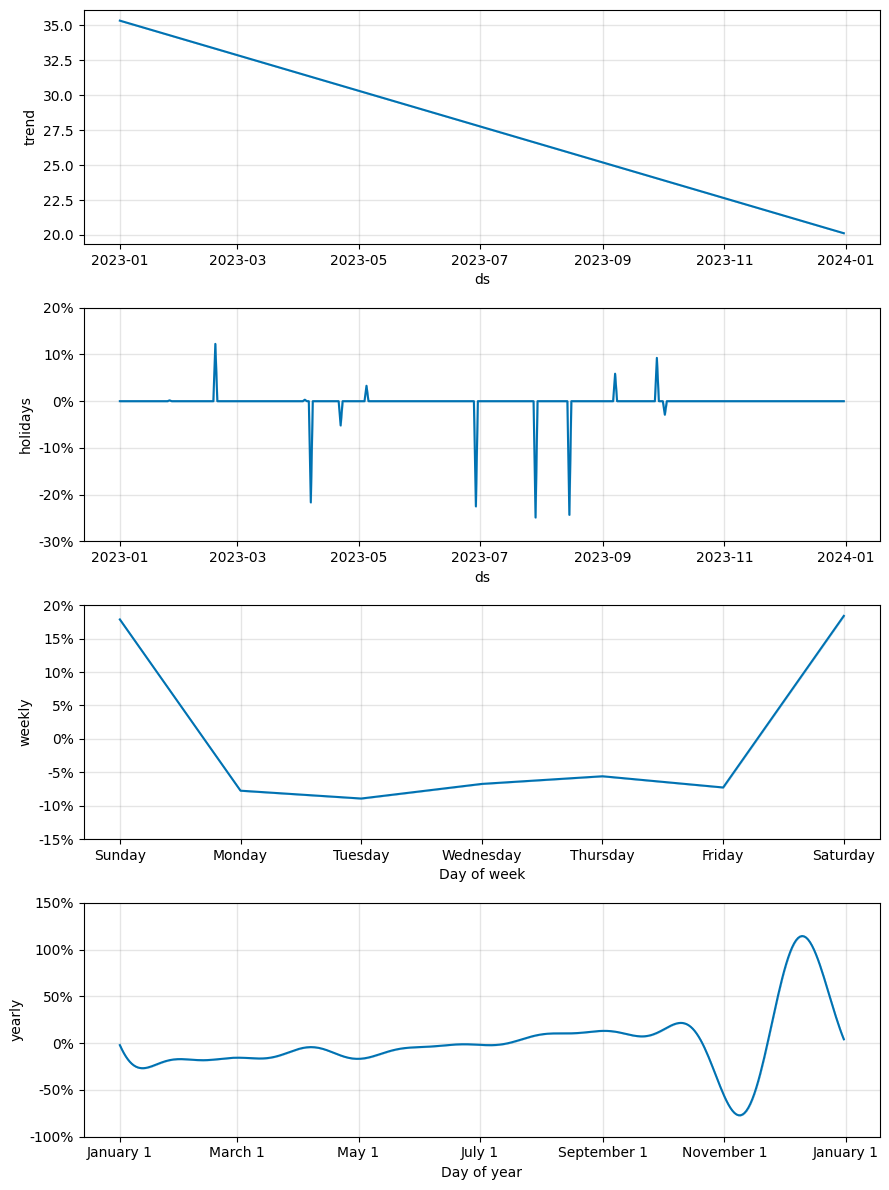


💾 Model saved to: ../models/prophet_Milk_1L.pkl


In [107]:
print("🤖 Training Prophet Model...")
print("="*50)

# Prophet requires specific column names: 'ds' (date) and 'y' (value)
prophet_train = train_df[['Date', 'QuantitySold']].copy()
prophet_train.columns = ['ds', 'y']

prophet_test = test_df[['Date', 'QuantitySold']].copy()
prophet_test.columns = ['ds', 'y']

# Initialize Prophet model
# yearly_seasonality: Capture annual patterns
# weekly_seasonality: Capture weekly patterns (weekends)
# daily_seasonality: Not needed for daily sales data
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # Sales grow proportionally
)

# Add Indian holidays (Diwali, Holi, etc.)
indian_holidays = pd.DataFrame({
    'holiday': ['Diwali', 'Holi', 'Dussehra', 'Eid'],
    'ds': pd.to_datetime(['2024-11-01', '2024-03-25', '2024-10-12', '2024-04-11'])
})

prophet_model = prophet_model.add_country_holidays(country_name='IN')

# Fit model
print("Training Prophet (this may take 30-60 seconds)...")
prophet_model.fit(prophet_train)
print("✅ Prophet model trained!")

# Make predictions
# Prophet needs future dates
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = prophet_model.predict(future)

# Extract test set predictions
prophet_predictions = forecast.iloc[-len(test_df):]['yhat'].values

# Evaluate
prophet_metrics = evaluate_model(
    test_df['QuantitySold'].values,
    prophet_predictions,
    "Prophet"
)

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['QuantitySold'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test_df['Date'], test_df['QuantitySold'], label='Actual Test Data', color='green', marker='o', markersize=4)
plt.plot(test_df['Date'], prophet_predictions, label='Prophet Predictions', color='purple', linestyle='--', marker='x', markersize=4)
plt.axvline(x=test_df['Date'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.title(f'{PRODUCT} - Prophet Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prophet components (trend, weekly, yearly)
fig = prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(prophet_model, f'../models/prophet_{PRODUCT}.pkl')
print(f"\n💾 Model saved to: ../models/prophet_{PRODUCT}.pkl")

📊 MODEL COMPARISON
               mae       rmse       mape        r2
model                                             
ARIMA     5.443948   7.999480  16.358261 -0.115401
Prophet  14.532515  18.090628  47.754755 -4.704465
LSTM      3.596770   4.383968  13.495847  0.028321


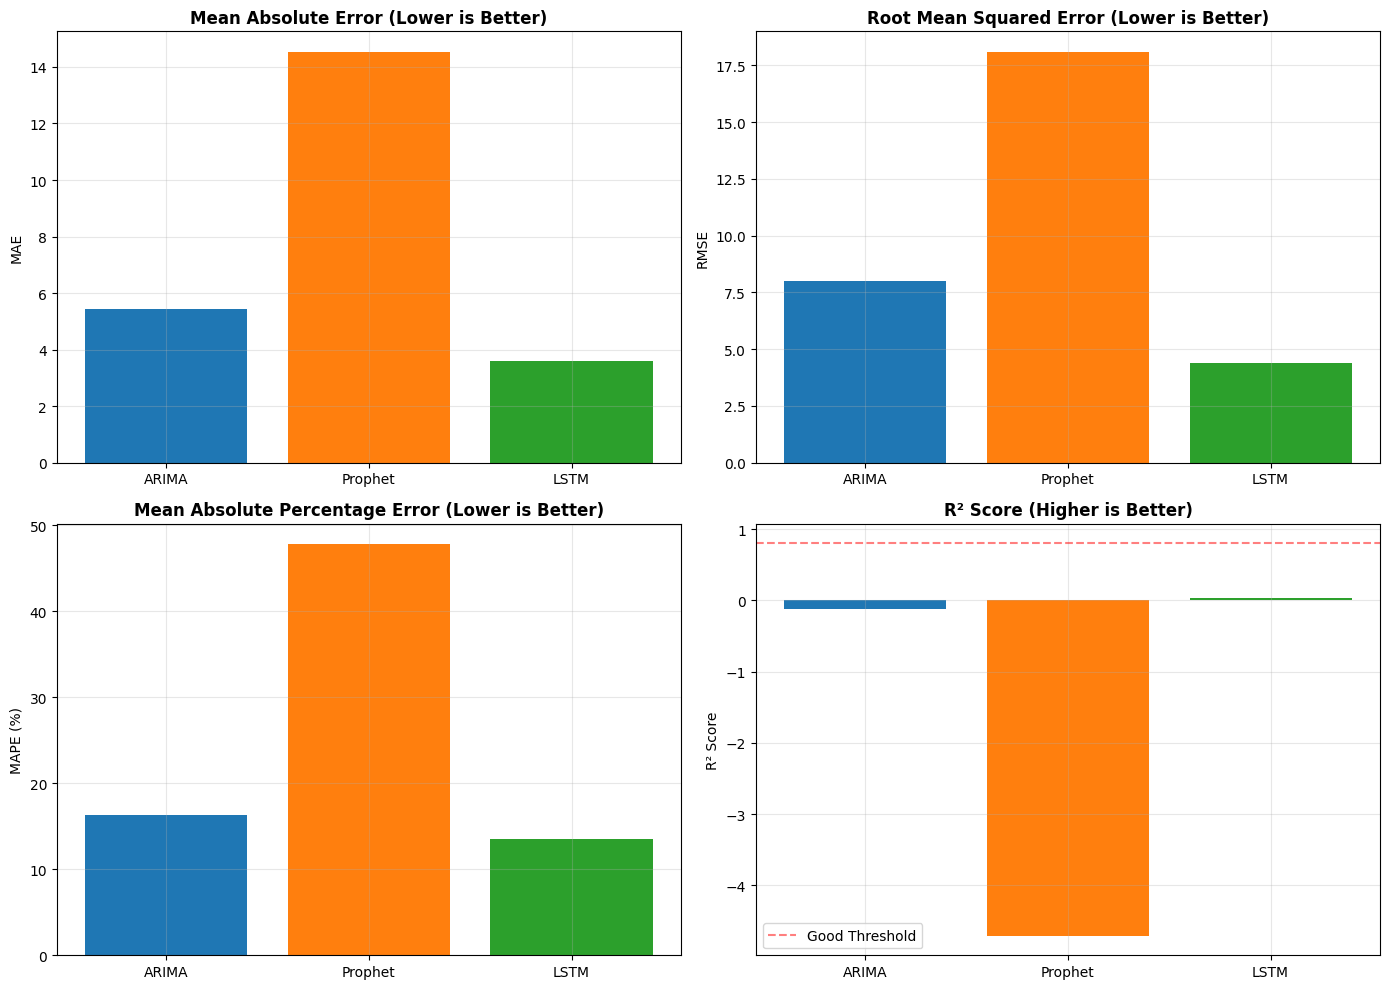


🏆 WINNER: LSTM (Lowest MAPE: 13.50%)

💾 Comparison saved to: ../models/model_comparison_Milk_1L.csv


In [108]:
print("📊 MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
comparison_df = pd.DataFrame([arima_metrics, prophet_metrics, lstm_metrics])
comparison_df = comparison_df.set_index('model')

print(comparison_df.to_string())

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE comparison
axes[0, 0].bar(comparison_df.index, comparison_df['mae'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('Mean Absolute Error (Lower is Better)', fontweight='bold')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison
axes[0, 1].bar(comparison_df.index, comparison_df['rmse'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_title('Root Mean Squared Error (Lower is Better)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True, alpha=0.3)

# MAPE comparison
axes[1, 0].bar(comparison_df.index, comparison_df['mape'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 0].set_title('Mean Absolute Percentage Error (Lower is Better)', fontweight='bold')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

# R² comparison
axes[1, 1].bar(comparison_df.index, comparison_df['r2'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_title('R² Score (Higher is Better)', fontweight='bold')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Good Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine best model
best_model = comparison_df['mape'].idxmin()  # Lowest MAPE
print(f"\n🏆 WINNER: {best_model} (Lowest MAPE: {comparison_df.loc[best_model, 'mape']:.2f}%)")

# Save comparison
comparison_df.to_csv(f'../models/model_comparison_{PRODUCT}.csv')
print(f"\n💾 Comparison saved to: ../models/model_comparison_{PRODUCT}.csv")

💾 Plot saved to: ../models/predictions_comparison_Milk_1L.png


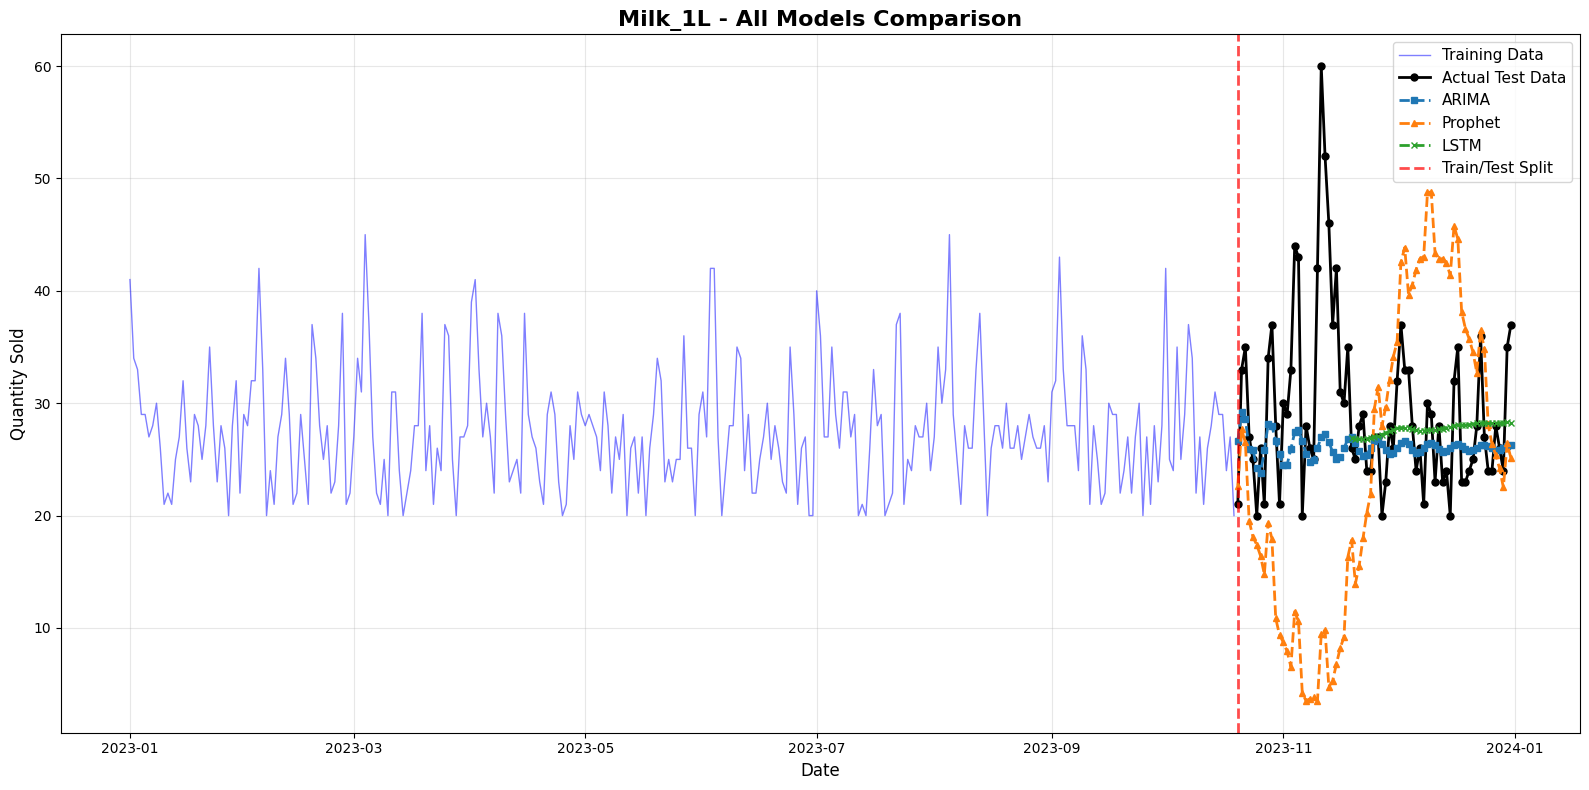

In [109]:
# Create comprehensive comparison plot
plt.figure(figsize=(16, 8))

# Plot actual data
plt.plot(train_df['Date'], train_df['QuantitySold'], 
         label='Training Data', color='blue', alpha=0.5, linewidth=1)
plt.plot(test_df['Date'], test_df['QuantitySold'], 
         label='Actual Test Data', color='black', linewidth=2, marker='o', markersize=5)

# Plot all predictions
plt.plot(test_df['Date'], arima_predictions, 
         label='ARIMA', linestyle='--', linewidth=2, marker='s', markersize=4)
plt.plot(test_df['Date'], prophet_predictions, 
         label='Prophet', linestyle='--', linewidth=2, marker='^', markersize=4)
plt.plot(test_dates_lstm, lstm_predictions, 
         label='LSTM', linestyle='--', linewidth=2, marker='x', markersize=5)

# Styling
plt.axvline(x=test_df['Date'].iloc[0], color='red', linestyle='--', 
            alpha=0.7, linewidth=2, label='Train/Test Split')
plt.title(f'{PRODUCT} - All Models Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig(f'../models/predictions_comparison_{PRODUCT}.png', dpi=300, bbox_inches='tight')
print(f"💾 Plot saved to: ../models/predictions_comparison_{PRODUCT}.png")
plt.show()

In [110]:
print("💼 BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*70)

# Calculate average prediction error
avg_actual = test_df['QuantitySold'].mean()
prophet_avg_error = prophet_metrics['mae']
error_percentage = (prophet_avg_error / avg_actual) * 100

print(f"\n📊 For {PRODUCT}:")
print(f"   Average daily sales: {avg_actual:.1f} units")
print(f"   Best model (Prophet) error: ±{prophet_avg_error:.1f} units ({error_percentage:.1f}%)")

print(f"\n🎯 What this means:")
if error_percentage < 10:
    print(f"   ✅ EXCELLENT: Predictions are highly accurate!")
    print(f"      → Can confidently use for inventory planning")
    print(f"      → Trust these forecasts for ordering decisions")
elif error_percentage < 20:
    print(f"   ✅ GOOD: Predictions are reliable!")
    print(f"      → Useful for general planning")
    print(f"      → Add small safety stock buffer")
else:
    print(f"   ⚠️  MODERATE: Predictions show trend but have variance")
    print(f"      → Use as guidance, not exact numbers")
    print(f"      → Maintain larger safety stock")

print(f"\n📈 Model Selection Advice:")
print(f"   • Use ARIMA for: Quick baseline, simple trends")
print(f"   • Use Prophet for: Seasonal products, holiday impacts (RECOMMENDED!)")
print(f"   • Use LSTM for: Complex patterns, when you have LOT of data")

print(f"\n💡 Next Steps:")
print(f"   1. Train models for ALL products (loop through product list)")
print(f"   2. Create weekly forecast reports")
print(f"   3. Build API to serve predictions")
print(f"   4. Set up automated retraining (weekly/monthly)")

print(f"\n🎉 Session 6 Complete! Models trained and saved!")

💼 BUSINESS INSIGHTS & RECOMMENDATIONS

📊 For Milk_1L:
   Average daily sales: 29.5 units
   Best model (Prophet) error: ±14.5 units (49.3%)

🎯 What this means:
   ⚠️  MODERATE: Predictions show trend but have variance
      → Use as guidance, not exact numbers
      → Maintain larger safety stock

📈 Model Selection Advice:
   • Use ARIMA for: Quick baseline, simple trends
   • Use Prophet for: Seasonal products, holiday impacts (RECOMMENDED!)
   • Use LSTM for: Complex patterns, when you have LOT of data

💡 Next Steps:
   1. Train models for ALL products (loop through product list)
   2. Create weekly forecast reports
   3. Build API to serve predictions
   4. Set up automated retraining (weekly/monthly)

🎉 Session 6 Complete! Models trained and saved!


In [112]:
# Train Prophet for ALL products
import joblib
from prophet import Prophet

print("🚀 Training Prophet models for all products...")
print("="*60)

products = df['ProductName'].unique()
results = []

for i, product in enumerate(products, 1):
    print(f"\n[{i}/15] Training: {product}")
    
    try:
        # Filter data
        product_df = df[df['ProductName'] == product].copy()
        product_df = product_df.sort_values('Date').reset_index(drop=True)
        
        # Split
        split_idx = int(len(product_df) * 0.8)
        train = product_df.iloc[:split_idx]
        
        # Prepare for Prophet
        prophet_train = train[['Date', 'QuantitySold']].copy()
        prophet_train.columns = ['ds', 'y']
        
        # Train
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        model.add_country_holidays(country_name='IN')
        model.fit(prophet_train)
        
        # Save
        model_path = f'../models/prophet_{product}.pkl'
        joblib.dump(model, model_path)
        
        print(f"   ✅ Saved: prophet_{product}.pkl")
        results.append({"product": product, "status": "✅ Success"})
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        results.append({"product": product, "status": f"❌ Failed: {str(e)}"})

print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)

# Show summary
import pandas as pd
summary_df = pd.DataFrame(results)
print(summary_df)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\iqx_gr2o.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\nqqsbkrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=50977', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\iqx_gr2o.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\nqqsbkrw.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelezqbvx0q\\prophet_model-20251220021744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


🚀 Training Prophet models for all products...

[1/15] Training: Amul_Ice_Cream


02:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\uk1md2x5.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\t4rcgn2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=69046', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\uk1md2x5.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\t4rcgn2_.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelgqcksd2m\\prophet_model-20251220021744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:44 - cmdstanpy - INFO - Cha

   ✅ Saved: prophet_Amul_Ice_Cream.pkl

[2/15] Training: Coca_Cola_1L


02:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


   ✅ Saved: prophet_Coca_Cola_1L.pkl

[3/15] Training: Colgate_Toothpaste


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\f5ovwccf.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\ghnooask.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=2032', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\f5ovwccf.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\ghnooask.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modeltejvuoqd\\prophet_model-20251220021745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe 

   ✅ Saved: prophet_Colgate_Toothpaste.pkl

[4/15] Training: Curd_500g


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\msm8jqzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=44421', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\keutoumr.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\msm8jqzo.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelc35hecqf\\prophet_model-20251220021745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input temp

   ✅ Saved: prophet_Curd_500g.pkl

[5/15] Training: Dettol_Soap


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=93526', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\zatr04n1.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\jad0x1tm.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelpi0v1upw\\prophet_model-20251220021745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\113qj52q.json
DEBUG:cmdstanpy:input temp

   ✅ Saved: prophet_Dettol_Soap.pkl

[6/15] Training: Kurkure


02:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


   ✅ Saved: prophet_Kurkure.pkl

[7/15] Training: Lays_Chips


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\f4xxs8xa.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\1gyw8jtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=27834', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\f4xxs8xa.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\1gyw8jtk.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelol72gkhd\\prophet_model-20251220021746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe

   ✅ Saved: prophet_Lays_Chips.pkl

[8/15] Training: Maggi_Pack


02:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


   ✅ Saved: prophet_Maggi_Pack.pkl

[9/15] Training: Milk_1L


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\im1u75r4.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\z0x9gjoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=76728', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\im1u75r4.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\z0x9gjoq.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modele_41eqsw\\prophet_model-20251220021747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe

   ✅ Saved: prophet_Milk_1L.pkl

[10/15] Training: Nescafe_Coffee


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\6wamth62.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\8du4gdgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=34536', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\6wamth62.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\8du4gdgt.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelvoy9x3wf\\prophet_model-20251220021747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

   ✅ Saved: prophet_Nescafe_Coffee.pkl

[11/15] Training: Paneer_200g


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\wu7uh7dd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=34584', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\vu_7ek6j.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\wu7uh7dd.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelojv_sj6a\\prophet_model-20251220021748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


   ✅ Saved: prophet_Paneer_200g.pkl

[12/15] Training: Parle_G_Biscuit


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\uf8pgadq.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\itupezny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=53130', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\uf8pgadq.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\itupezny.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelj_7h8bcw\\prophet_model-20251220021748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe

   ✅ Saved: prophet_Parle_G_Biscuit.pkl

[13/15] Training: Rice_5kg


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\tnaqui5h.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\7xhfnx4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=38142', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\tnaqui5h.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\7xhfnx4i.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelzerm5g93\\prophet_model-20251220021749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe

   ✅ Saved: prophet_Rice_5kg.pkl

[14/15] Training: Tata_Tea_250g


DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\scgng2ta.json
DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\_6zjgouk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=96874', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\scgng2ta.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\_6zjgouk.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_modelzzgzpsxr\\prophet_model-20251220021749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1]

   ✅ Saved: prophet_Tata_Tea_250g.pkl

[15/15] Training: Wheat_Atta_10kg


DEBUG:cmdstanpy:input tempfile: C:\Users\karta\AppData\Local\Temp\tmpn9lof_sq\rt2phrnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\karta\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=73264', 'data', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\_n_zjy1_.json', 'init=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\rt2phrnv.json', 'output', 'file=C:\\Users\\karta\\AppData\\Local\\Temp\\tmpn9lof_sq\\prophet_model520vpo6k\\prophet_model-20251220021750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


   ✅ Saved: prophet_Wheat_Atta_10kg.pkl

🎉 TRAINING COMPLETE!
               product     status
0       Amul_Ice_Cream  ✅ Success
1         Coca_Cola_1L  ✅ Success
2   Colgate_Toothpaste  ✅ Success
3            Curd_500g  ✅ Success
4          Dettol_Soap  ✅ Success
5              Kurkure  ✅ Success
6           Lays_Chips  ✅ Success
7           Maggi_Pack  ✅ Success
8              Milk_1L  ✅ Success
9       Nescafe_Coffee  ✅ Success
10         Paneer_200g  ✅ Success
11     Parle_G_Biscuit  ✅ Success
12            Rice_5kg  ✅ Success
13       Tata_Tea_250g  ✅ Success
14     Wheat_Atta_10kg  ✅ Success
